# Libraries

##  Remove warnings

In [1225]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [1226]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# Torch libraries
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.EarlyStopping      import *
from utils.LRScheduler        import *

# Parameters

## CUDA

In [1227]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            device = torch.device( 'cuda:0' ) 
            
            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:
            
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
            device = torch.device( 'cpu' )
except:
    device = torch.device( 'cpu' )
    print('[INFO] Not GPU found - CPU selected')

[INFO] Not GPU found - CPU selected


## Neural networks parameters

In [1228]:
class Parameters():
    def __init__(self):
        self.description = 'DLinear model for time-series forecasting'
    
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Neural network model parameters
        #
        # Input sequence length - look-back
        self.Lag         = 3 * 24
        # Prediction sequence length
        self.Horizon     = 24
        #
        self.individual  = False
        self.enc_in      = 1
        self.kernel_size = 25
        
        # Training parameters
        #
        # Number of epochs
        self.epochs        = 1000
        # Batch size
        self.batch_size    = 32
        # Number of workers in DataLoader
        self.num_workers   = 0
        # Define verbose
        self.verbose       = True
        # Learning rate
        self.learning_rate = 1e-4
        # Trained model path
        self.model_path    = 'models/DLinear.pth'
        
        # Data handling
        #
        # Filename
        self.filename              = './data/EEM.csv'
        # Target series name 
        self.targetSeries          = 'Return'
        # Training-set percentage
        self.TrainingSetPercentage = 0.8
        # Data Log-transformation
        self.Transformation        = False
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'

args = Parameters()

# Data handling

## Import data


In [1229]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( args.filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.00 seconds


date       Open       High        Low      Close  Adj Close    Volume  \
0  2019/10/1  40.900002  40.910000  40.549999  40.580002  37.171913  48520000   
1  2019/10/2  40.279999  40.340000  40.070000  40.270000  36.887951  41806300   
2  2019/10/3  40.410000  40.790001  40.299999  40.790001  37.364273  62287700   

     Return  
0  1.000000  
1  0.992361  
2  1.005175

## Preprocess data

### Set index

In [1230]:
# Convert Date to 'datetime64'
#
df['date'] = df['date'].astype('datetime64[ns]')

# Set index
#
df.set_index('date', inplace=True)


# Keep only selected time-series
#
df = pd.DataFrame( df[ [ args.targetSeries ] ] )


df.head( 3 )

Return
date                
2019-10-01  1.000000
2019-10-02  0.992361
2019-10-03  1.005175

### Split Training/Testing

In [1231]:
idx = int( df.shape[0] * args.TrainingSetPercentage )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

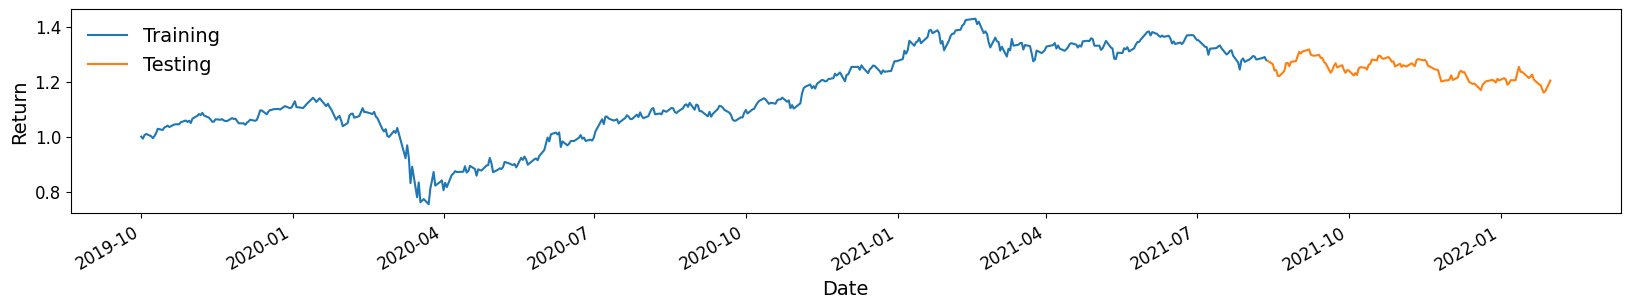

In [1232]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ args.targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ args.targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(args.targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [1233]:
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])

## Preprocessing

## Data Transformation

In [1234]:
if (args.Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] No data transformation applied.


In [1235]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
            
elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
        
elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )             
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard


## Create Training/Testing data

In [1236]:
def create_dataset(df = None, Lag = 1, Horizon = 1, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY, dataDate = [], [], []
    
    # 起始日期是df.shape[0] + 1  - Lag - Horizon，预测的时间间隔是overlap
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() )
        
    return ( np.array(dataX), np.array(dataY), np.array(dataDate) )
df_test

Return
date                
2021-05-03  1.152210
2021-05-04  1.058790
2021-05-05  1.097077
2021-05-06  1.175182
2021-05-07  1.260944
...              ...
2022-01-25  0.270085
2022-01-26  0.176665
2022-01-27  0.092435
2022-01-28  0.127658
2022-01-31  0.365036

[190 rows x 1 columns]

In [1237]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 2021-05-03 to 2022-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Return  190 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [1238]:
trainX, trainY, _ = create_dataset(df           = df_train, 
                                   Lag          = args.Lag, 
                                   Horizon      = args.Horizon, 
                                   targetSeries = args.targetSeries,
                                   overlap      = 1,)
                        

testX,  testY, testDate  = create_dataset(df           = df_test, 
                                          Lag          = args.Lag, 
                                          Horizon      = args.Horizon, 
                                          targetSeries = args.targetSeries,
                                          overlap      = 1,)


# Last 10% of the training data will be used for validation
#
idx = int(0.9 * trainX.shape[0])
validX, validY = trainX[ idx: ], trainY[ idx: ]
trainX, trainY = trainX[ :idx ], trainY[ :idx ]

print('Training data shape:   ', trainX.shape, trainY.shape)
print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

100%|██████████| 95/95 [00:00<00:00, 31769.96it/s]

Training data shape:    (338, 72, 1) (338, 24)
Validation data shape:  (38, 72, 1) (38, 24)
Testing data shape:     (95, 72, 1) (95, 24)


In [1239]:
testDate

array([[Timestamp('2021-08-13 00:00:00'),
        Timestamp('2021-08-16 00:00:00'),
        Timestamp('2021-08-17 00:00:00'),
        Timestamp('2021-08-18 00:00:00'),
        Timestamp('2021-08-19 00:00:00'),
        Timestamp('2021-08-20 00:00:00'),
        Timestamp('2021-08-23 00:00:00'),
        Timestamp('2021-08-24 00:00:00'),
        Timestamp('2021-08-25 00:00:00'),
        Timestamp('2021-08-26 00:00:00'),
        Timestamp('2021-08-27 00:00:00'),
        Timestamp('2021-08-30 00:00:00'),
        Timestamp('2021-08-31 00:00:00'),
        Timestamp('2021-09-01 00:00:00'),
        Timestamp('2021-09-02 00:00:00'),
        Timestamp('2021-09-03 00:00:00'),
        Timestamp('2021-09-07 00:00:00'),
        Timestamp('2021-09-08 00:00:00'),
        Timestamp('2021-09-09 00:00:00'),
        Timestamp('2021-09-10 00:00:00'),
        Timestamp('2021-09-13 00:00:00'),
        Timestamp('2021-09-14 00:00:00'),
        Timestamp('2021-09-15 00:00:00'),
        Timestamp('2021-09-16 00:0

In [1240]:
# Reshaping
#
trainY = np.expand_dims(trainY, axis = -1)
validY = np.expand_dims(validY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

In [1241]:
class Data( Dataset ):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[ idx ], self.Y[ idx ]
    

    
# Create training and test dataloaders
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)


# Prepare Data-Loaders
#
train_dl = DataLoader(train_ds, batch_size = args.batch_size, num_workers = args.num_workers)
valid_dl = DataLoader(valid_ds, batch_size = args.batch_size, num_workers = args.num_workers)
test_dl  = DataLoader(test_ds,  batch_size = args.batch_size, num_workers = args.num_workers)
#
print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# Forecasting model: DLinear

In [1242]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.Lag  = configs.Lag
        self.Horizon = configs.Horizon
        # Model中的参数只有Lag和Horizon
        # 用Lag天的数据预测Horizon天的数据

        # Decompsition Kernel Size
        kernel_size       = configs.kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual   = configs.individual
        self.channels     = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend    = nn.ModuleList()
            self.Linear_Decoder  = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Trend.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Decoder.append(nn.Linear(self.Lag,self.Horizon))
        else:
            self.Linear_Seasonal = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Trend = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Decoder = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
            self.Linear_Trend.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.Horizon],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.Horizon],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## Setup model

In [1243]:
# Initialize Neural Network
# 
model = Model( args )

model.to( device )


print( model )

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=72, out_features=24, bias=True)
  (Linear_Trend): Linear(in_features=72, out_features=24, bias=True)
  (Linear_Decoder): Linear(in_features=72, out_features=24, bias=True)
)


## Training parameters

In [1244]:
# Specify loss function
#
criterion = nn.MSELoss()

# Specify loss function
#
optimizer = torch.optim.Adam(params = model.parameters(), 
                             lr     = args.learning_rate)




# Early stopping
#
early_stopping = EarlyStopping(patience  = 100,
                               min_delta = 1e-5)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 50, 
                        min_lr    = 1e-10, 
                        factor    = 0.5, 
                        verbose   = args.verbose)

## Training process

In [1245]:
# Store training and validation loss
Loss = {
         'Train': [], 
         'Valid':  []
       }



# Set number at how many iteration the training process (results) will be provided
#
batch_show = (train_dl.dataset.__len__() // args. batch_size // 5)



# Main loop - Training process
#
for epoch in range(1, args.epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor training loss
    #
    train_loss = 0.0
    valid_loss  = 0.0    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data, target in train_dl:
        
        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()

            
        outputs = model( data )
        

        
        # Calculate the loss
        #
        loss = criterion(outputs, target)
        
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item()*data.size(0)
               
        # Increase batch_idx
        #
        batch_idx  += 1
        
        
        # Info
        #
        if (args.verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(epoch, batch_idx * len(data), len(train_dl.dataset), 100. * batch_idx / len(train_dl)))        

           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / train_dl.dataset.X.shape[0]

    
    
    
    
    with torch.no_grad():
        for data, target in valid_dl:

            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if (device.type == 'cpu'):
                data   = torch.tensor(data, dtype=torch.float32)
                target = torch.tensor(target, dtype=torch.float32)
            else:
                data   = torch.tensor(data, dtype=torch.float32).cuda()
                target = torch.tensor(target, dtype=torch.float32).cuda()

            
            outputs = model( data )
             
            # Calculate the loss
            #
            loss = criterion(outputs, target)
                
            # update running training loss
            valid_loss += loss.item()*data.size(0)
        

    # Print avg training statistics 
    #
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]






    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('\n[INFO] Train Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start), end=' ')

   
    

    # Update best model
    #
    if (epoch == 1):
        Best_score = valid_loss
        
        torch.save(model, args.model_path)
        print('(Model saved)\n')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss
            
            torch.save(model, args.model_path)
            print('(Model saved)\n')
        else:
            print('\n')
     
    
    # Store train/val loss
    #
    Loss['Train'] += [ train_loss ]
    Loss['Valid'] += [ valid_loss ]
    

    
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler( valid_loss )
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping( valid_loss ) ): break

> Epoch: 1 [   64/338 (18%)]
> Epoch: 1 [  128/338 (36%)]
> Epoch: 1 [  192/338 (55%)]
> Epoch: 1 [  256/338 (73%)]
> Epoch: 1 [  320/338 (91%)]

[INFO] Train Loss: 0.523031	Valid Loss: 0.021564 	Time: 0.01secs (Model saved)

> Epoch: 2 [   64/338 (18%)]
> Epoch: 2 [  128/338 (36%)]
> Epoch: 2 [  192/338 (55%)]
> Epoch: 2 [  256/338 (73%)]
> Epoch: 2 [  320/338 (91%)]

[INFO] Train Loss: 0.511427	Valid Loss: 0.021418 	Time: 0.01secs (Model saved)

> Epoch: 3 [   64/338 (18%)]
> Epoch: 3 [  128/338 (36%)]
> Epoch: 3 [  192/338 (55%)]
> Epoch: 3 [  256/338 (73%)]
> Epoch: 3 [  320/338 (91%)]

[INFO] Train Loss: 0.502242	Valid Loss: 0.021387 	Time: 0.01secs (Model saved)

> Epoch: 4 [   64/338 (18%)]
> Epoch: 4 [  128/338 (36%)]
> Epoch: 4 [  192/338 (55%)]
> Epoch: 4 [  256/338 (73%)]
> Epoch: 4 [  320/338 (91%)]

[INFO] Train Loss: 0.493628	Valid Loss: 0.021482 	Time: 0.01secs 

> Epoch: 5 [   64/338 (18%)]
> Epoch: 5 [  128/338 (36%)]
> Epoch: 5 [  192/338 (55%)]
> Epoch: 5 [  256/338 

> Epoch: 51 [  192/338 (55%)]
> Epoch: 51 [  256/338 (73%)]
> Epoch: 51 [  320/338 (91%)]

[INFO] Train Loss: 0.286943	Valid Loss: 0.027129 	Time: 0.01secs 

> Epoch: 52 [   64/338 (18%)]
> Epoch: 52 [  128/338 (36%)]
> Epoch: 52 [  192/338 (55%)]
> Epoch: 52 [  256/338 (73%)]
> Epoch: 52 [  320/338 (91%)]

[INFO] Train Loss: 0.284703	Valid Loss: 0.027151 	Time: 0.01secs 

> Epoch: 53 [   64/338 (18%)]
> Epoch: 53 [  128/338 (36%)]
> Epoch: 53 [  192/338 (55%)]
> Epoch: 53 [  256/338 (73%)]
> Epoch: 53 [  320/338 (91%)]

[INFO] Train Loss: 0.282518	Valid Loss: 0.027172 	Time: 0.01secs 

> Epoch: 54 [   64/338 (18%)]
> Epoch: 54 [  128/338 (36%)]
> Epoch: 54 [  192/338 (55%)]
> Epoch: 54 [  256/338 (73%)]
> Epoch: 54 [  320/338 (91%)]

[INFO] Train Loss: 0.280386	Valid Loss: 0.027192 	Time: 0.01secs 

Epoch    54: reducing learning rate of group 0 to 5.0000e-05.
> Epoch: 55 [   64/338 (18%)]
> Epoch: 55 [  128/338 (36%)]
> Epoch: 55 [  192/338 (55%)]
> Epoch: 55 [  256/338 (73%)]
> Epoc

## Load optimized model

In [1246]:
print(len(outputs[0]))


24


In [1247]:
# Load best model
# eval模式模型不更新连接权
model = torch.load( args.model_path ) 
model.eval()

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [1248]:
# 这里传入model的data是4个torch：
# torch.Size([32, 72, 1])
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):
        data   = torch.tensor(data,   dtype=torch.float32)
        print(data.shape)
        target = torch.tensor(target, dtype=torch.float32)
        print(target.shape)
        if (pred is None):
            pred = model( data ).numpy()
        else:
            pred = np.concatenate([pred, model( data ).numpy()])
    

100%|██████████| 3/3 [00:00<00:00, 1003.42it/s]

torch.Size([32, 72, 1])
torch.Size([32, 24, 1])
torch.Size([32, 72, 1])
torch.Size([32, 24, 1])
torch.Size([31, 72, 1])
torch.Size([31, 24, 1])


In [1249]:
print(test_dl.dataset.X.shape)
test_dl.dataset.Y.shape

(95, 72, 1)


(95, 24, 1)

In [1250]:
# Reshaping...
#
testY = testY.squeeze(-1)
pred  = pred.squeeze(-1)
pred

array([[1.2516437 , 1.0003082 , 1.0148969 , 0.95479137, 1.0898495 ,
        1.004388  , 1.0605745 , 1.1047375 , 1.0602748 , 1.0731127 ,
        0.9454945 , 1.05624   , 1.1103334 , 1.2232132 , 1.2179798 ,
        1.272459  , 1.0648296 , 1.1842909 , 1.1974137 , 1.000893  ,
        1.2163125 , 1.2522427 , 1.0935396 , 1.0059985 ],
       [1.2462462 , 0.9955479 , 1.0100789 , 0.9499396 , 1.0847405 ,
        0.99942625, 1.0556437 , 1.0997947 , 1.0553932 , 1.0683347 ,
        0.94098973, 1.0517013 , 1.1058437 , 1.2187098 , 1.2134936 ,
        1.2679065 , 1.0602977 , 1.1796944 , 1.1926774 , 0.996296  ,
        1.211543  , 1.2475259 , 1.0890559 , 1.0017025 ],
       [1.2409673 , 0.99043137, 1.0048608 , 0.94477224, 1.0795345 ,
        0.99442685, 1.0505495 , 1.0947459 , 1.0505693 , 1.0636846 ,
        0.93647647, 1.0471141 , 1.1012453 , 1.2140034 , 1.2087587 ,
        1.2630388 , 1.0556184 , 1.1746839 , 1.1876267 , 0.9915571 ,
        1.2065752 , 1.2426434 , 1.0845447 , 0.99742347],
       [1.232

### Apply inverse scaling/transformation

In [1251]:
# Apply inverse scaling
#
for i in range( args.Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (args.Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE
pred

array([[1.3462116, 1.3057694, 1.3081169, 1.2984455, 1.3201774, 1.3064259,
        1.3154669, 1.3225731, 1.3154187, 1.3174844, 1.2969495, 1.3147694,
        1.3234736, 1.3416369, 1.3407948, 1.349561 , 1.3161516, 1.335374 ,
        1.3374856, 1.3058636, 1.3405265, 1.346308 , 1.3207712, 1.3066851],
       [1.3453431, 1.3050035, 1.3073417, 1.2976648, 1.3193554, 1.3056276,
        1.3146734, 1.3217778, 1.3146331, 1.3167156, 1.2962246, 1.3140391,
        1.322751 , 1.3409122, 1.3400729, 1.3488284, 1.3154223, 1.3346343,
        1.3367234, 1.3051239, 1.339759 , 1.345549 , 1.3200498, 1.3059939],
       [1.3444936, 1.3041803, 1.3065021, 1.2968333, 1.3185177, 1.3048232,
        1.3138537, 1.3209654, 1.313857 , 1.3159673, 1.2954984, 1.313301 ,
        1.3220112, 1.340155 , 1.339311 , 1.3480452, 1.3146694, 1.3338281,
        1.3359107, 1.3043613, 1.3389597, 1.3447634, 1.3193239, 1.3053054],
       [1.3431449, 1.3028662, 1.3051829, 1.2955372, 1.3172154, 1.3035479,
        1.3125808, 1.3197021, 1.312

In [1252]:
np.set_printoptions(threshold=np.inf)
pred

array([[1.3462116, 1.3057694, 1.3081169, 1.2984455, 1.3201774, 1.3064259,
        1.3154669, 1.3225731, 1.3154187, 1.3174844, 1.2969495, 1.3147694,
        1.3234736, 1.3416369, 1.3407948, 1.349561 , 1.3161516, 1.335374 ,
        1.3374856, 1.3058636, 1.3405265, 1.346308 , 1.3207712, 1.3066851],
       [1.3453431, 1.3050035, 1.3073417, 1.2976648, 1.3193554, 1.3056276,
        1.3146734, 1.3217778, 1.3146331, 1.3167156, 1.2962246, 1.3140391,
        1.322751 , 1.3409122, 1.3400729, 1.3488284, 1.3154223, 1.3346343,
        1.3367234, 1.3051239, 1.339759 , 1.345549 , 1.3200498, 1.3059939],
       [1.3444936, 1.3041803, 1.3065021, 1.2968333, 1.3185177, 1.3048232,
        1.3138537, 1.3209654, 1.313857 , 1.3159673, 1.2954984, 1.313301 ,
        1.3220112, 1.340155 , 1.339311 , 1.3480452, 1.3146694, 1.3338281,
        1.3359107, 1.3043613, 1.3389597, 1.3447634, 1.3193239, 1.3053054],
       [1.3431449, 1.3028662, 1.3051829, 1.2955372, 1.3172154, 1.3035479,
        1.3125808, 1.3197021, 1.312

In [1253]:
pred[0].shape

(24,)

### Calculate Performance on Testing set - Prediction visualization


In [1254]:
print('[INFO] Feature: ', args.targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( args.Horizon ):

    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

[INFO] Feature:  Return
------------------------------------------------
Horizon:  1 MAE  0.05 RMSE  0.06 SMAPE:  4.20 R2: -2.41
Horizon:  2 MAE  0.03 RMSE  0.03 SMAPE:  2.10 R2: 0.04
Horizon:  3 MAE  0.03 RMSE  0.03 SMAPE:  2.19 R2: -0.04
Horizon:  4 MAE  0.02 RMSE  0.03 SMAPE:  2.00 R2: 0.20
Horizon:  5 MAE  0.03 RMSE  0.04 SMAPE:  2.71 R2: -0.52
Horizon:  6 MAE  0.03 RMSE  0.03 SMAPE:  2.14 R2: 0.07
Horizon:  7 MAE  0.03 RMSE  0.04 SMAPE:  2.50 R2: -0.22
Horizon:  8 MAE  0.04 RMSE  0.04 SMAPE:  2.89 R2: -0.55
Horizon:  9 MAE  0.03 RMSE  0.04 SMAPE:  2.54 R2: -0.21
Horizon: 10 MAE  0.03 RMSE  0.04 SMAPE:  2.68 R2: -0.32
Horizon: 11 MAE  0.02 RMSE  0.03 SMAPE:  1.95 R2: 0.34
Horizon: 12 MAE  0.03 RMSE  0.04 SMAPE:  2.55 R2: -0.23
Horizon: 13 MAE  0.04 RMSE  0.05 SMAPE:  3.05 R2: -0.72
Horizon: 14 MAE  0.06 RMSE  0.06 SMAPE:  4.40 R2: -2.17
Horizon: 15 MAE  0.06 RMSE  0.06 SMAPE:  4.41 R2: -2.26
Horizon: 16 MAE  0.07 RMSE  0.07 SMAPE:  5.14 R2: -3.34
Horizon: 17 MAE  0.04 RMSE  0.04 SM

### Residual examination

In [1255]:
Prices

Return  Prediction
0   1.271316    1.306685
1   1.265894    1.305994
2   1.231888    1.305305
3   1.241005    1.304171
4   1.256530    1.302779
..       ...         ...
90  1.188270    1.234306
91  1.173238    1.232789
92  1.159685    1.231391
93  1.165352    1.230076
94  1.203548    1.228963

[95 rows x 2 columns]

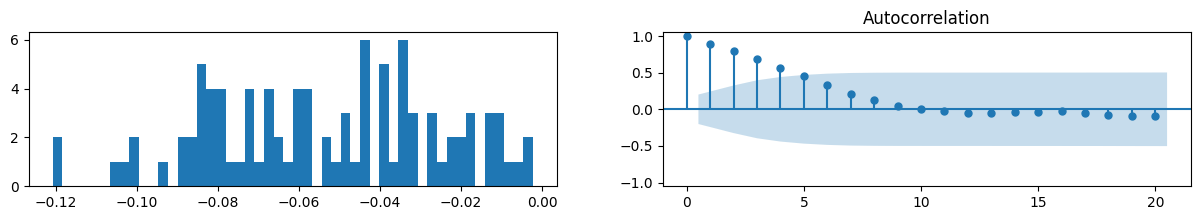

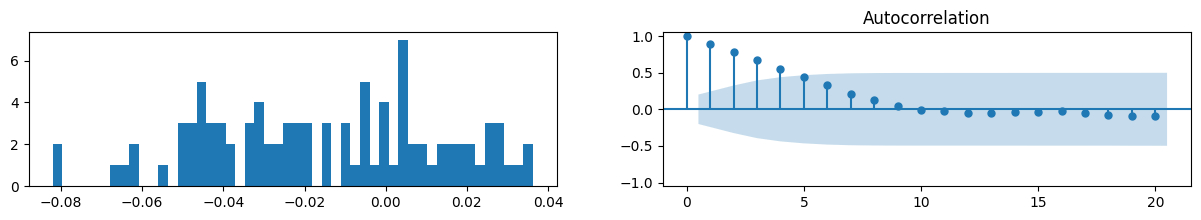

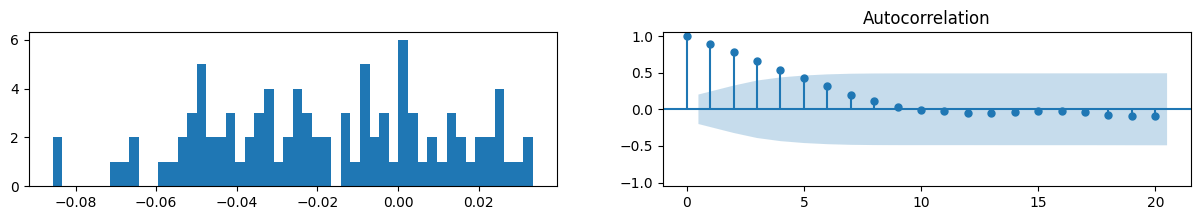

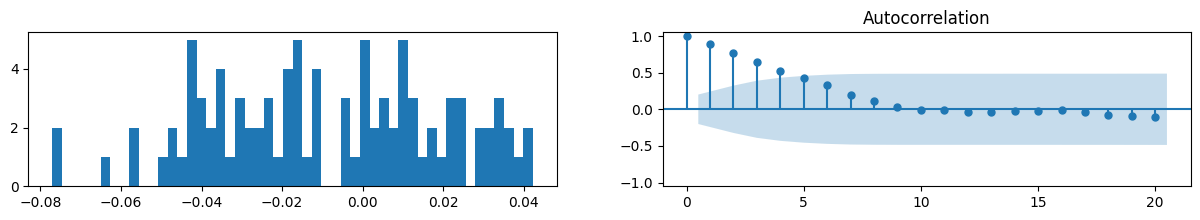

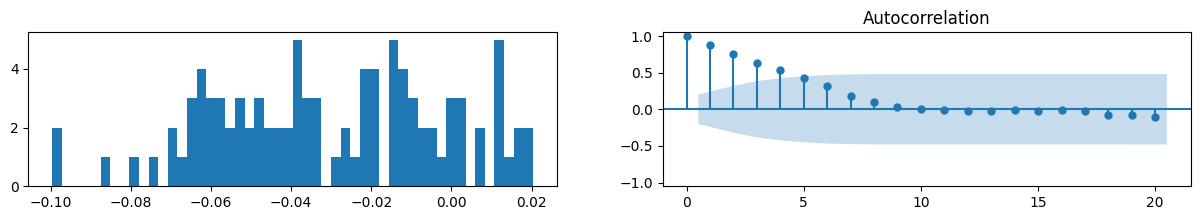

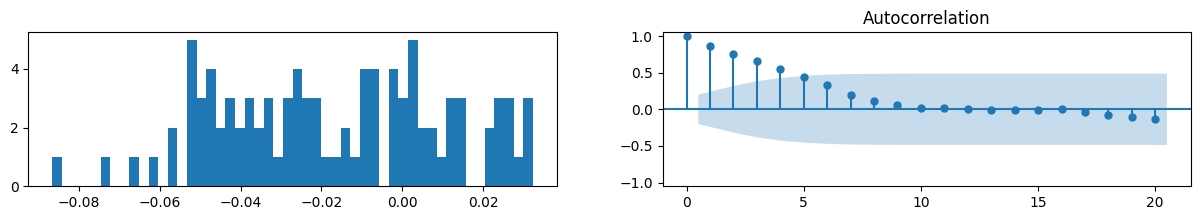

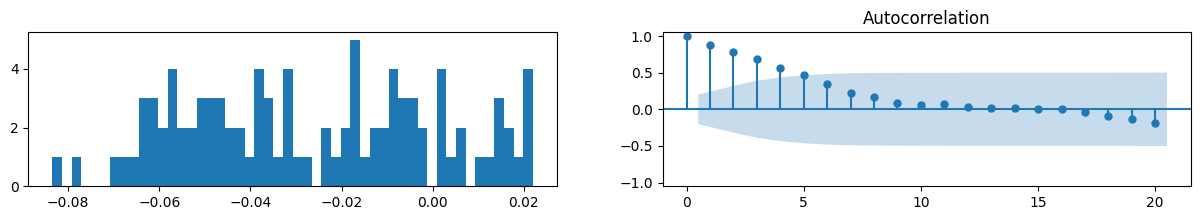

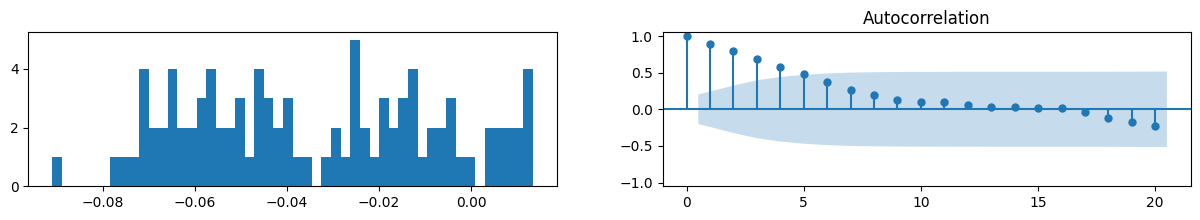

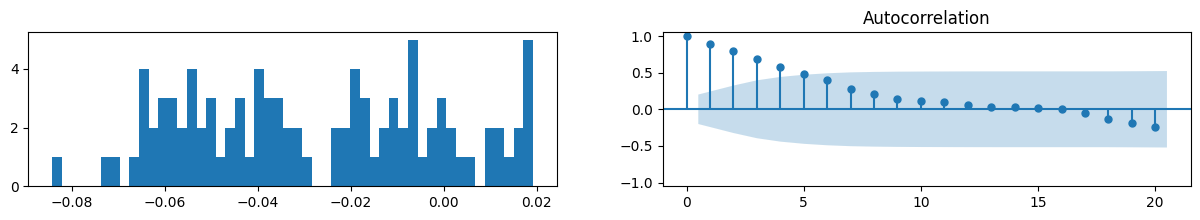

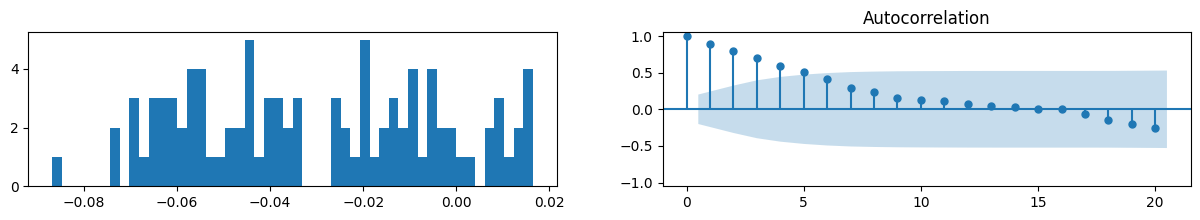

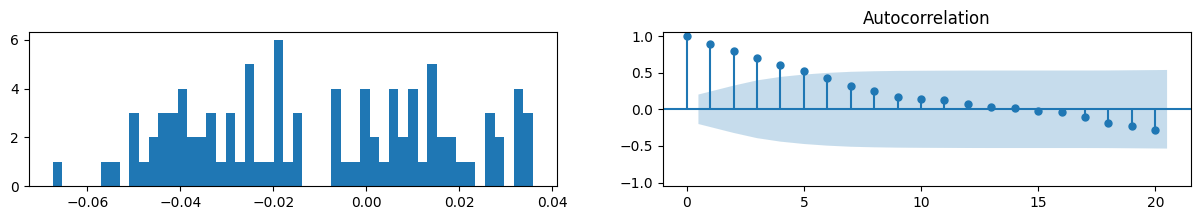

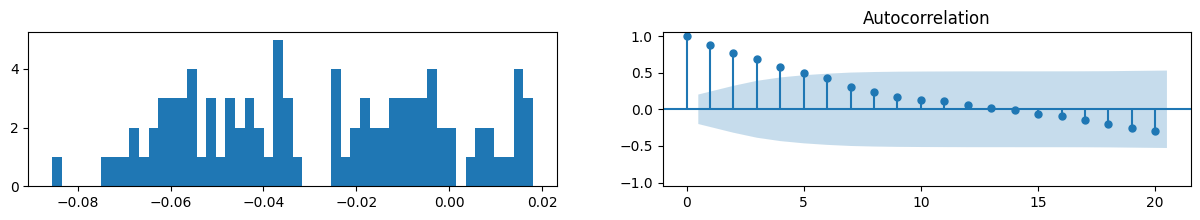

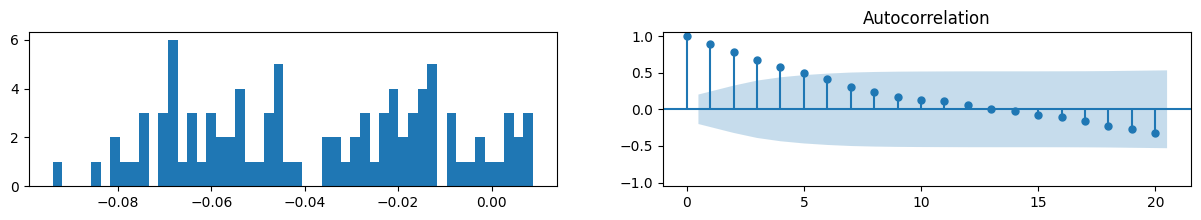

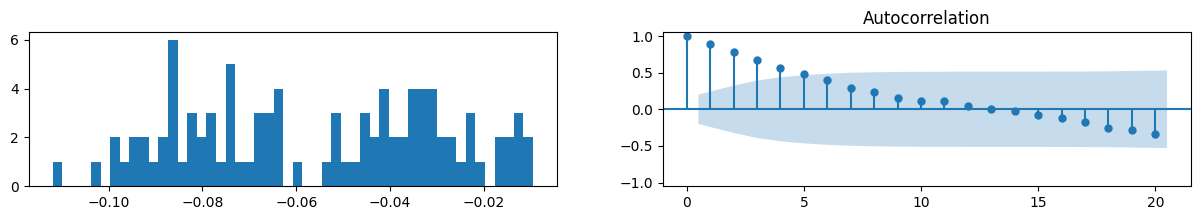

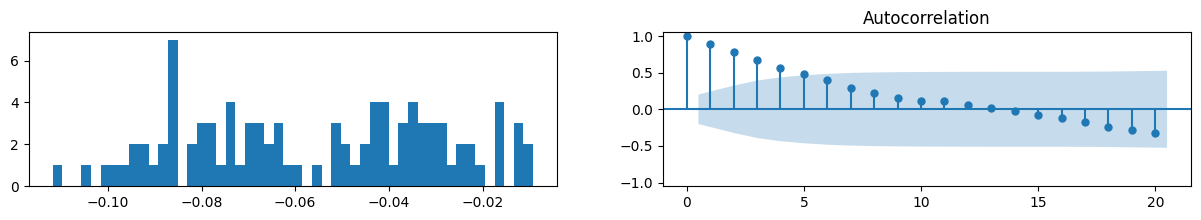

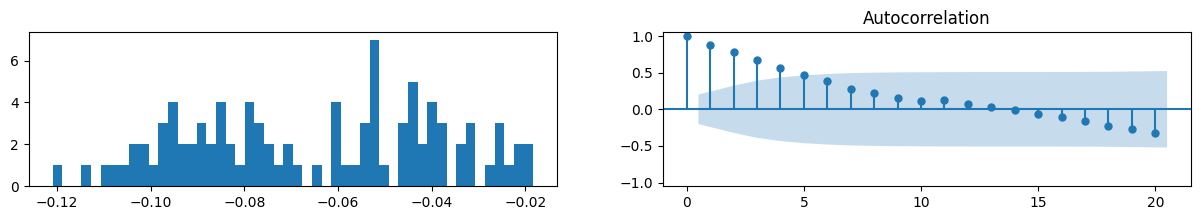

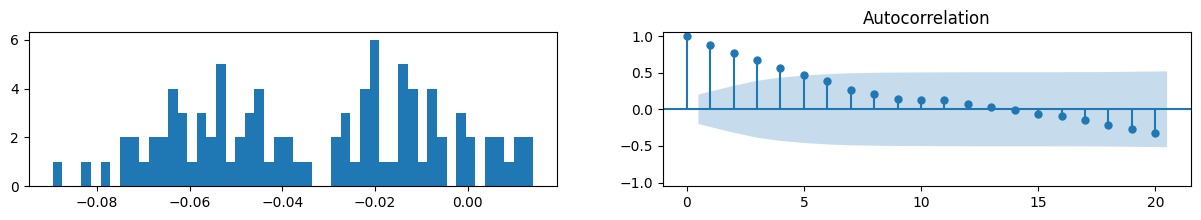

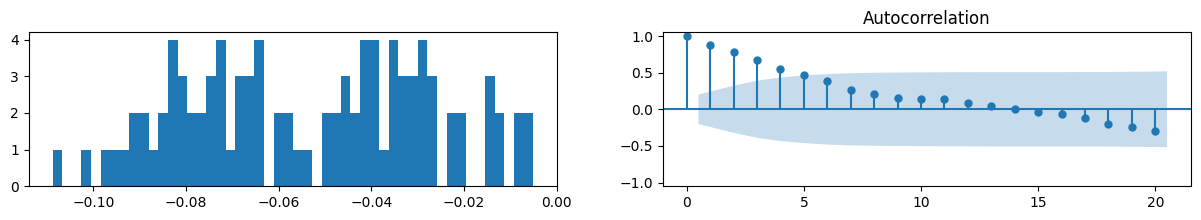

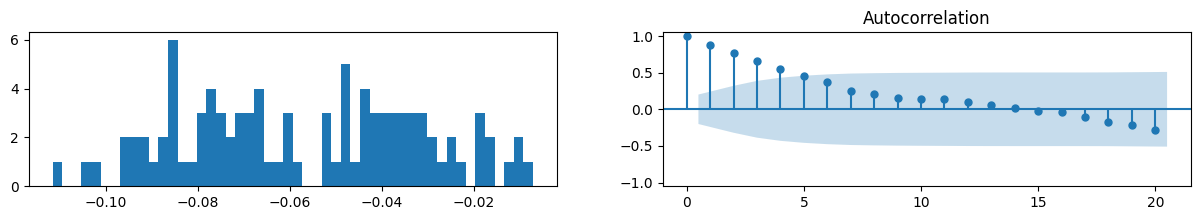

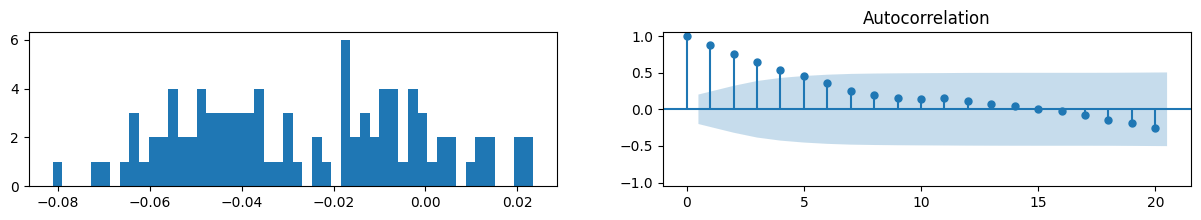

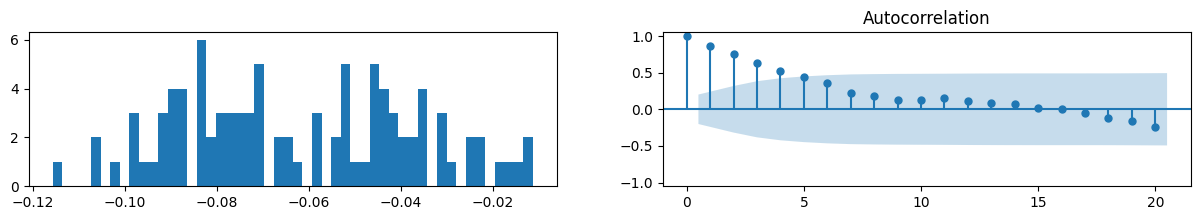

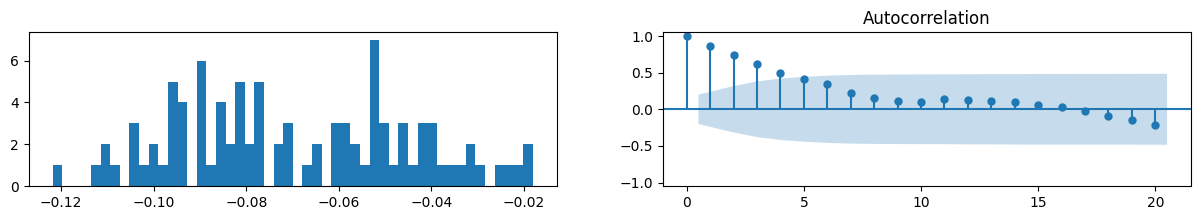

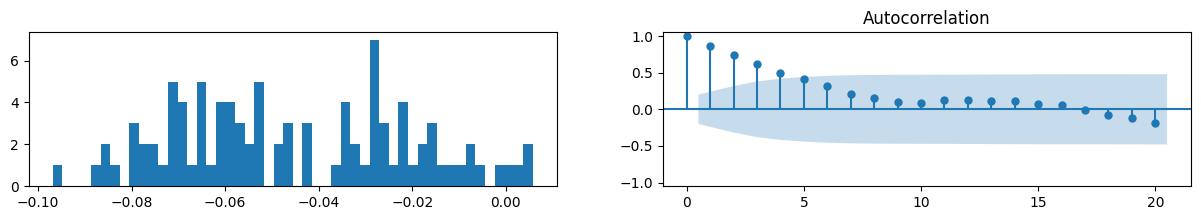

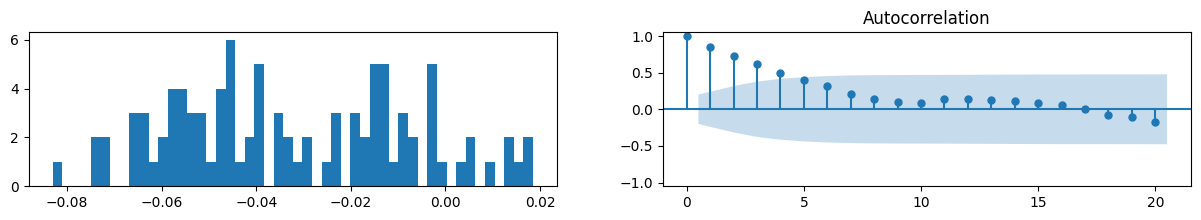

In [1256]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

for i in range( args.Horizon ):

    # Get actual values and predicted
    #
    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]
                        
    # Calculate the residuals
    #
    res = (Prices[ args.targetSeries ] - Prices['Prediction']).to_numpy()
    
    
    
    # === Visualization ===
    #
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    # Plot residual histogram
    #
    ax[0].hist(res, bins = 50)    
    
    # Plot AutoCorrelation plot
    #
    plot_acf( res, ax=ax[1] )       
    ax[1].set_ylim([-1.05, 1.05])

## Examples

In [1257]:
testY

array([[1.27476583, 1.26318374, 1.24001965, 1.24199111, 1.22079839,
        1.21981266, 1.23829467, 1.26638731, 1.26786591, 1.25579095,
        1.27131587, 1.27402657, 1.29152286, 1.3080335 , 1.30211922,
        1.30901914, 1.3166584 , 1.29743714, 1.29497282, 1.29349432,
        1.29694427, 1.28610144, 1.28585505, 1.27131587],
       [1.26318374, 1.24001965, 1.24199111, 1.22079839, 1.21981266,
        1.23829467, 1.26638731, 1.26786591, 1.25579095, 1.27131587,
        1.27402657, 1.29152286, 1.3080335 , 1.30211922, 1.30901914,
        1.3166584 , 1.29743714, 1.29497282, 1.29349432, 1.29694427,
        1.28610144, 1.28585505, 1.27131587, 1.26589445],
       [1.24001965, 1.24199111, 1.22079839, 1.21981266, 1.23829467,
        1.26638731, 1.26786591, 1.25579095, 1.27131587, 1.27402657,
        1.29152286, 1.3080335 , 1.30211922, 1.30901914, 1.3166584 ,
        1.29743714, 1.29497282, 1.29349432, 1.29694427, 1.28610144,
        1.28585505, 1.27131587, 1.26589445, 1.23188761],
       [1.241

In [1258]:
# # Apply inverse scaling on trainX
# #
# for i in range( trainX.shape[1] ):
#     testX[:,  i, 0] = scaler.inverse_transform( testX[:, i, 0].reshape(-1,1) ).squeeze(-1)


# # Apply inverse transformation   
# #
# if (Transformation == True):
#     testX = np.exp( testX ) - VALUE

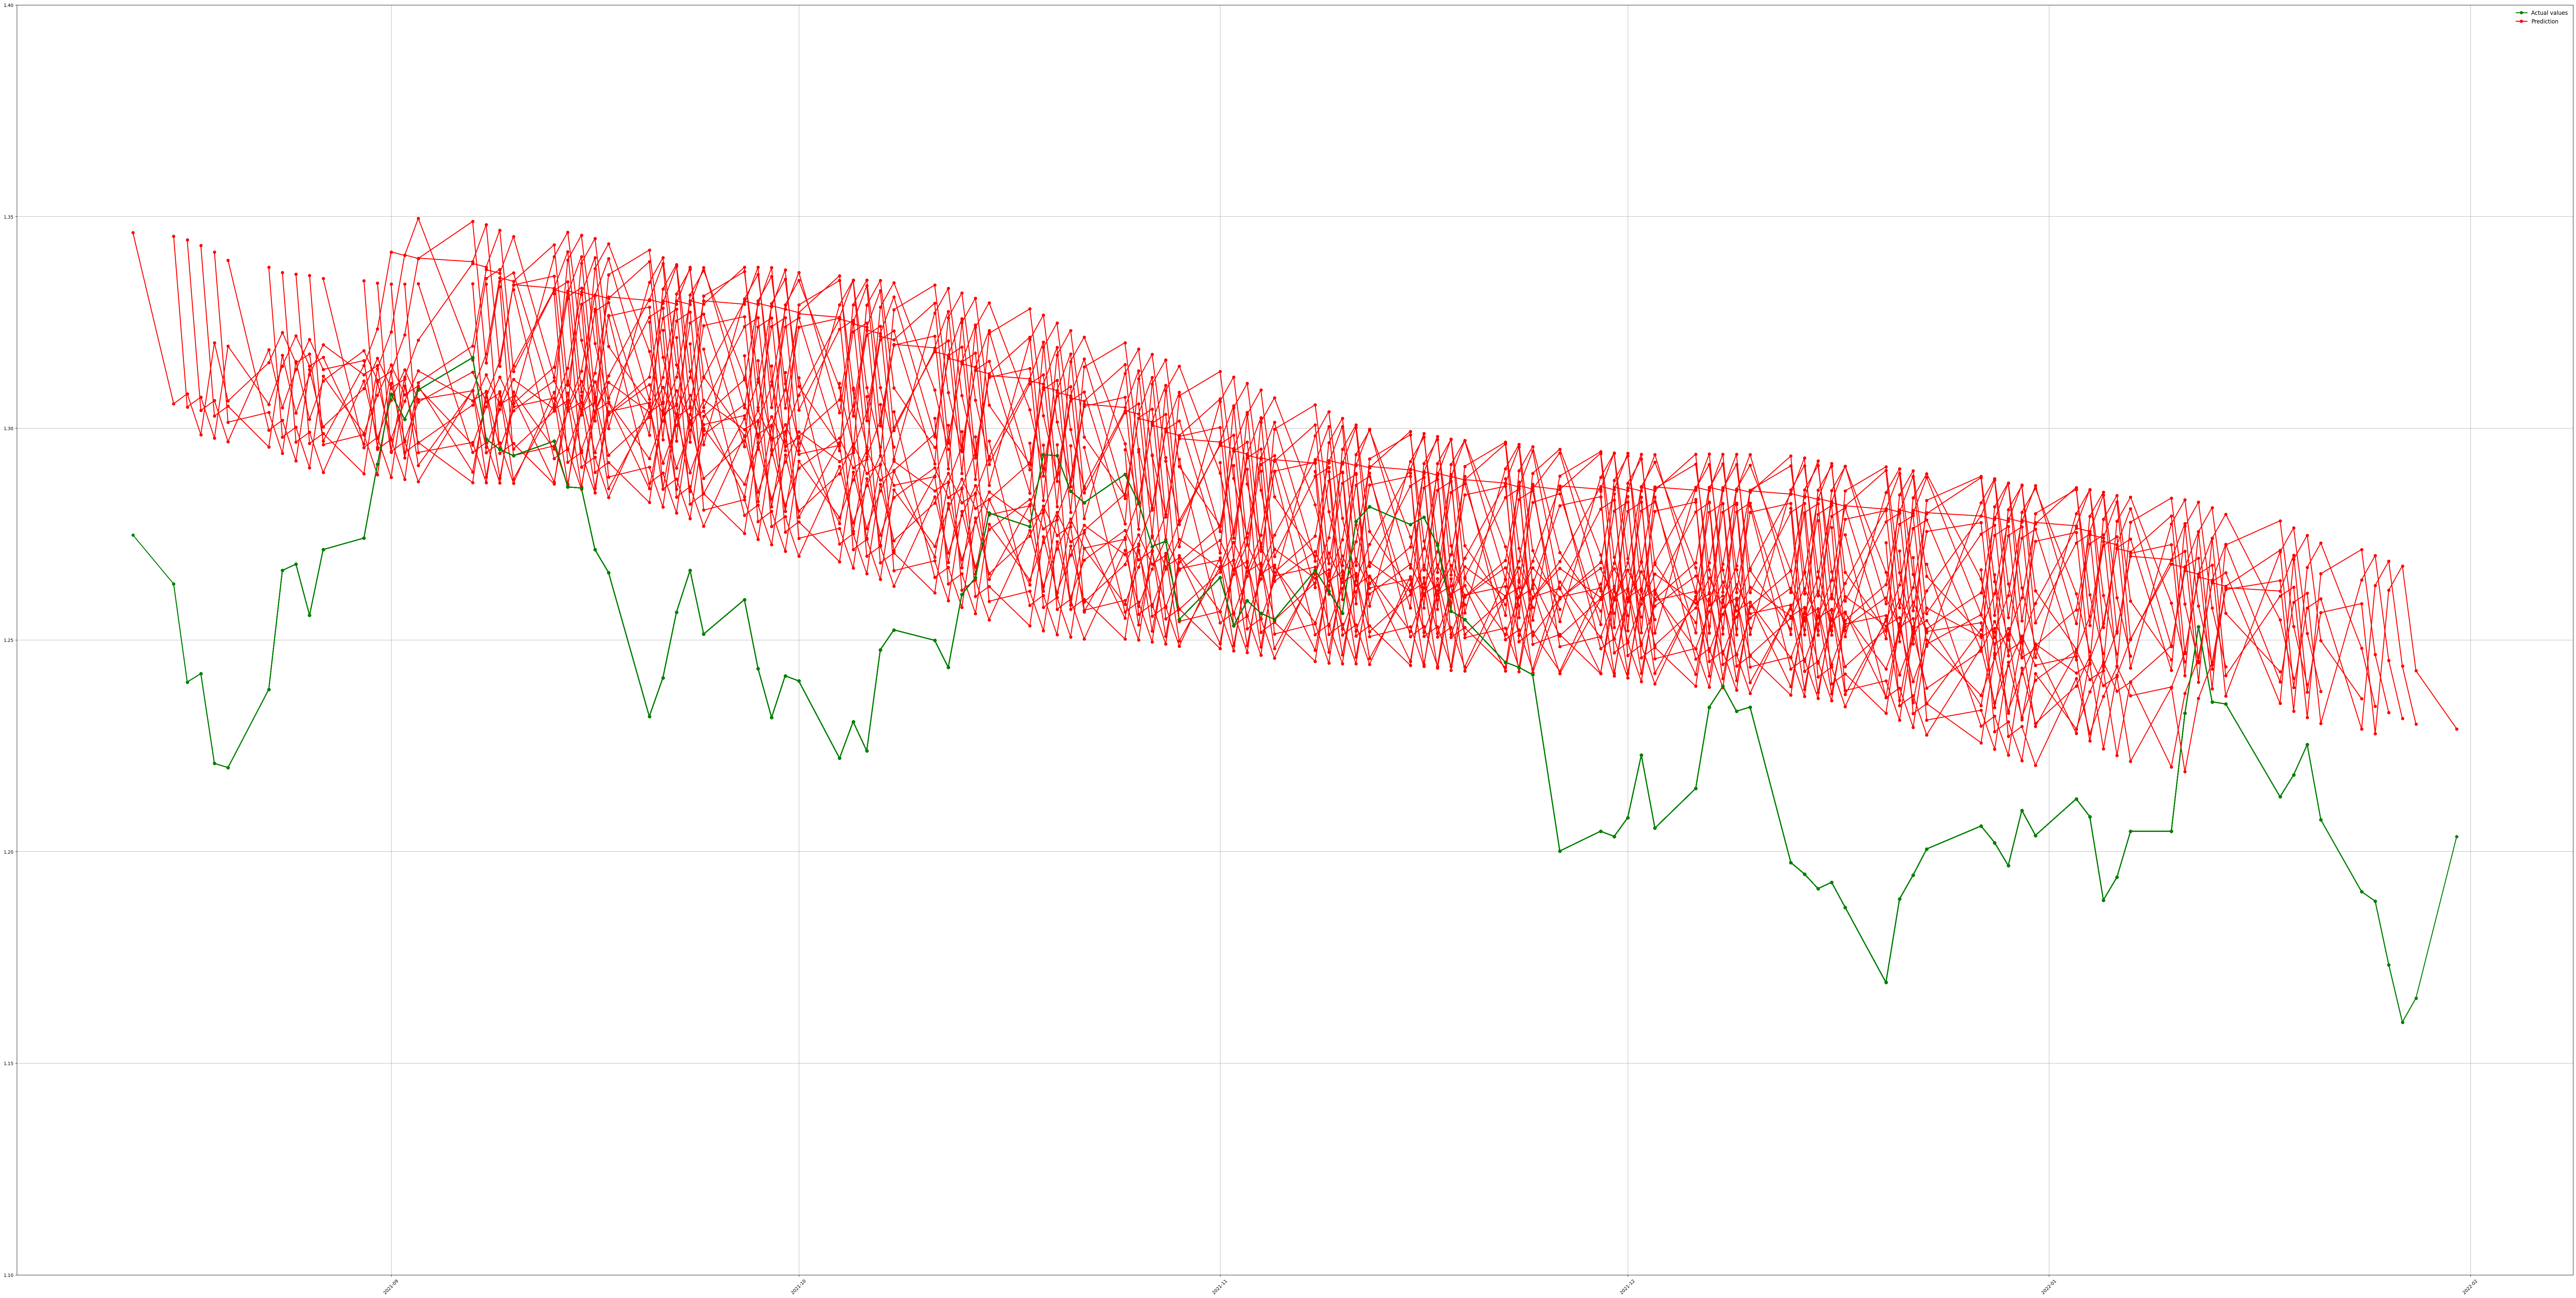

In [1262]:
plt.figure(figsize=(100, 50))

for i in range(len(testY)):
    plt.plot(testDate[i], testY[i], color='g', marker='o', linewidth=2)
    plt.plot(testDate[i], pred[i], color='r', marker='o', linewidth=2)

plt.legend(['Actual values', 'Prediction'], frameon=False, fontsize=12)
plt.ylim([1.1, 1.4])
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [1260]:
testDate

array([[Timestamp('2021-08-13 00:00:00'),
        Timestamp('2021-08-16 00:00:00'),
        Timestamp('2021-08-17 00:00:00'),
        Timestamp('2021-08-18 00:00:00'),
        Timestamp('2021-08-19 00:00:00'),
        Timestamp('2021-08-20 00:00:00'),
        Timestamp('2021-08-23 00:00:00'),
        Timestamp('2021-08-24 00:00:00'),
        Timestamp('2021-08-25 00:00:00'),
        Timestamp('2021-08-26 00:00:00'),
        Timestamp('2021-08-27 00:00:00'),
        Timestamp('2021-08-30 00:00:00'),
        Timestamp('2021-08-31 00:00:00'),
        Timestamp('2021-09-01 00:00:00'),
        Timestamp('2021-09-02 00:00:00'),
        Timestamp('2021-09-03 00:00:00'),
        Timestamp('2021-09-07 00:00:00'),
        Timestamp('2021-09-08 00:00:00'),
        Timestamp('2021-09-09 00:00:00'),
        Timestamp('2021-09-10 00:00:00'),
        Timestamp('2021-09-13 00:00:00'),
        Timestamp('2021-09-14 00:00:00'),
        Timestamp('2021-09-15 00:00:00'),
        Timestamp('2021-09-16 00:0

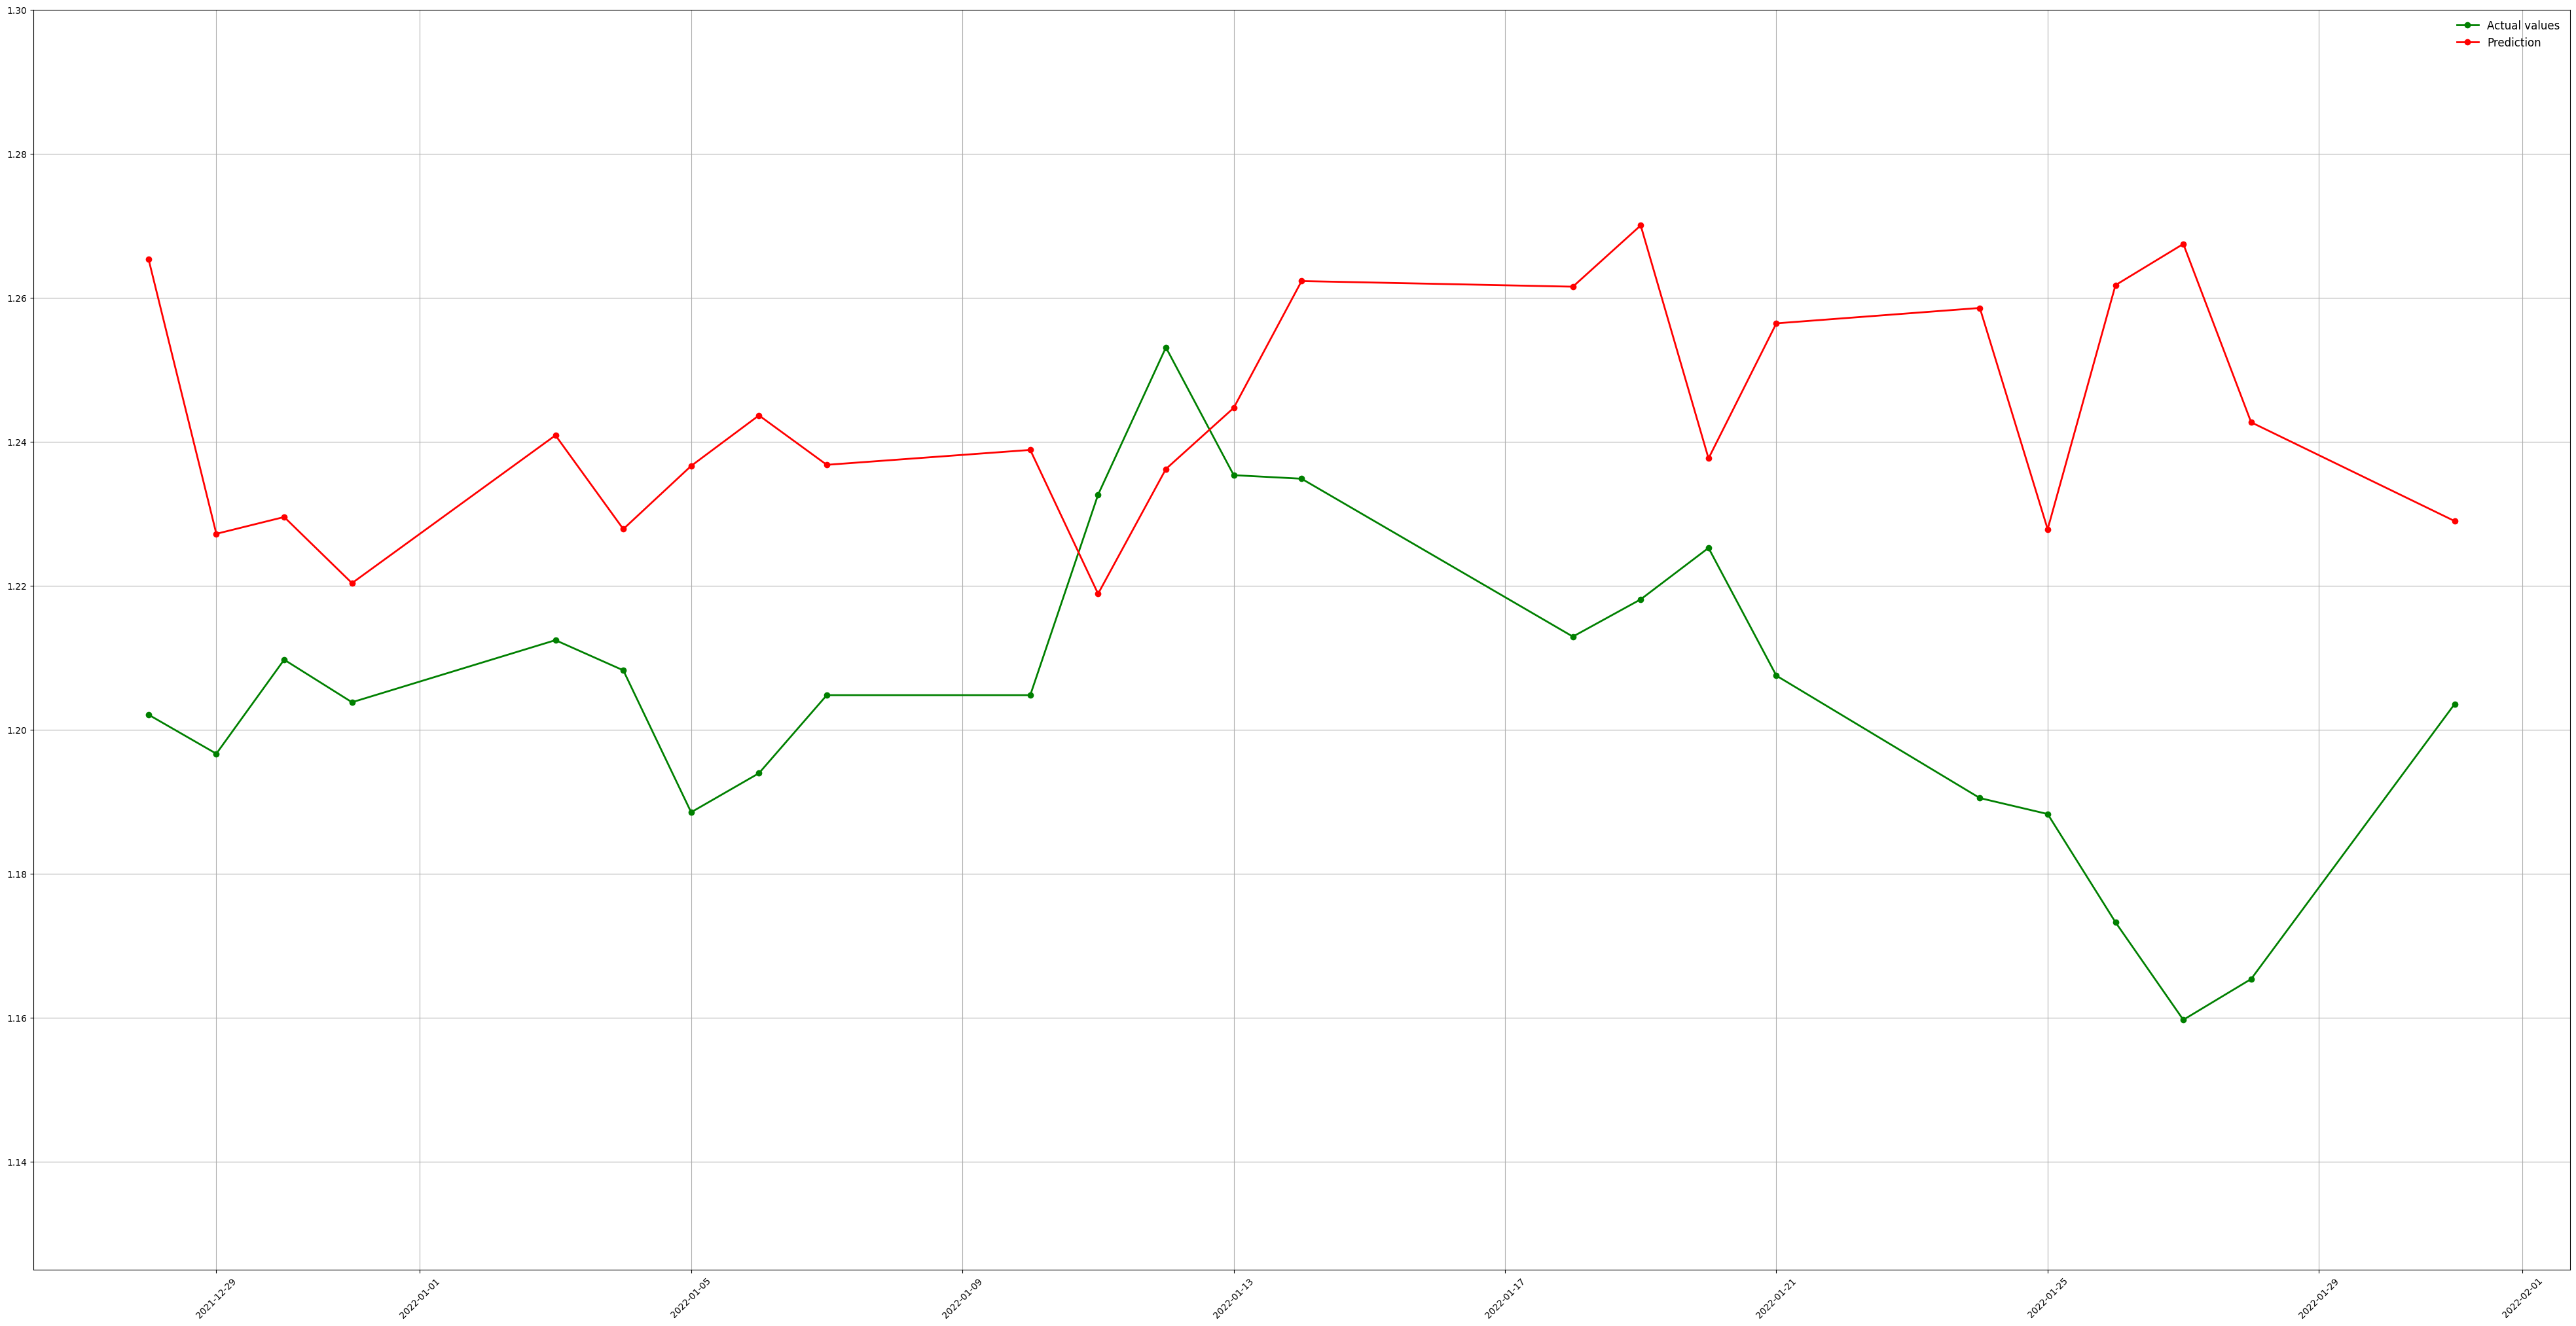

In [1261]:
plt.figure(figsize=(50, 25))


plt.plot(testDate[-1], testY[-1], color='g', marker='o', linewidth=2)
plt.plot(testDate[-1], pred[-1], color='r', marker='o', linewidth=2)

plt.legend(['Actual values', 'Prediction'], frameon=False, fontsize=12)
plt.ylim([1.125, 1.3])
plt.xticks(rotation=45)
plt.grid()
plt.show()